In [1]:
import numpy as np
import cvxpy as cp 
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'
from IPython.display import clear_output
import time
clear_output()

In [2]:
"""
data 
"""

np.random.seed(23824)

TOLDIV = 5e-10
MIT = 2.5e3

d = int(1e3)
fade_cand = -2/3
fade = max(-10,min(1,fade_cand))
p = 1
R_def = 10

In [3]:
# from INRIA 
def proj_simplex_(vec, R=1,tol=1e-3):
    """ 
    References
    ----------
    [1] Efficient Projections onto the .1-Ball for Learning in High Dimensions
        John Duchi, Shai Shalev-Shwartz, Yoram Singer, and Tushar Chandra.
        International Conference on Machine Learning (ICML 2008)
        http://www.cs.berkeley.edu/~jduchi/projects/DuchiSiShCh08.pdf
    """
    assert R > 0, "radius R must be strictly positive (%d <= 0)" % R
    d, = vec.shape  # will raise ValueError if vec is not 1-D
    if abs(vec.sum() - R)<=tol and np.alltrue(vec >= 0):
        return vec
    sorted_vec = np.sort(vec)[::-1]
    cssv = np.cumsum(sorted_vec)
    buf = np.nonzero(sorted_vec * np.arange(1, d+1) > (cssv - R))[0][-1]
    shift = float(cssv[buf] - R) / (1+buf)
    w = (vec - shift).clip(min=0)
    return w

def proj_ball_(x,xi_embd=np.zeros(d),nm_power=p,R=R_def,tol=5e-4):
    dxxi_embd = x-xi_embd
    abs_dxxi_embd = np.abs(dxxi_embd)
    if nm_power==1:
        if np.sum(abs_dxxi_embd)<=R+tol:
            return x
        return xi_embd + proj_simplex_(abs_dxxi_embd,R)*np.sign(dxxi_embd)
    elif nm_power==np.inf:
        if max(abs_dxxi_embd)<=R+tol:
            return x
        return xi_embd + np.minimum(R,np.maximum(-R,dxxi_embd))
    elif nm_power==2:
        buf = (np.sum(abs_dxxi_embd**2))**(1/2)
        if buf<=R+tol:
            return x
        return xi_embd + dxxi_embd*R/max(R,buf)
    else:
        return None

In [4]:
# from deepseek

def split_matrix(U):
    # Compute the eigenvalues and eigenvectors of U
    eigvals, eigvecs = np.linalg.eigh(U)
    
    # Split the eigenvalues into positive and negative parts
    lambda_plus = np.maximum(eigvals, 0)
    lambda_minus = np.maximum(-eigvals, 0)
    
    # Construct the diagonal matrices for positive and negative parts
    Lambda_plus = np.diag(lambda_plus)
    Lambda_minus = np.diag(lambda_minus)
    
    # Reconstruct U1 and U2 using the eigenvectors
    U1 = eigvecs @ Lambda_plus @ eigvecs.T
    U2 = eigvecs @ Lambda_minus @ eigvecs.T
    
    return (U1+U1.T)/2, (U2+U2.T)/2

In [5]:
def SDCe(MO,f1,f2,Psi,F,x_init,L_init,desc_prop=.1,tau_loc=2/3,ns_trig=5,dc_steps=int(200),\
            reset_after_ls=False,max_iter=1000,verb=False,vb_freq=50):
    
    # inits.
    tau_ext = .001
    x_stability_prev_next,x_stability_prev,x_stability,x,L = x_init.copy(),x_init.copy(),x_init.copy(),x_init.copy(),L_init
    k = 0
    div_succ_it = np.inf
    num_streak_success = 0
    L_min,L_max,L_prev = 1,1e16,0
    th,th_prev,varsigma = 1,0,0
    
    DCA_useful_iters = 0

    cond = True
    
    while k<max_iter and div_succ_it>TOLDIV and L<L_max:
                
        # IO
        y = x_stability+min(np.sqrt(L_prev*(1-tau_ext)/L),varsigma)*(x_stability_prev_next-x_stability_prev)
        f1y,g1y = f1(y,mode='full')
        f1y_tilde = f1y-np.sum(g1y*y)
        if cond:
            f2x,g2x = f2(x=x_stability,mode='full')
            f2x_stability,g2x_stability = f2x,g2x
            f2x_stability_tilde = f2x_stability-np.sum(g2x_stability*x_stability)
            val = f1(x_stability,'value')-f2x_stability+Psi(x_stability)

        cond = False
        
        if num_streak_success>=ns_trig:
            L = max(L_min+0.01,L*tau_loc)
            if reset_after_ls:
                num_streak_success = 0
            
        # MO 
        x_stability_plus,x,DCA_inner = MO(y,g1y,f1y_tilde,g2x_stability,f2x_stability_tilde,L,max_steps=dc_steps,min_decr_inner=5e-4)

        # IO 
        f1x,g1x = f1(x,mode='full')
        val_new = f1x-f2(x,'value')+Psi(x)
        
        # potential sufficient decrease check 
        div_ = np.sum((x-y)**2)/2
        div_x_stab_x_stab_plus = np.sum((x_stability_plus-x_stability)**2)/2
        cond = val_new + L*div_x_stab_x_stab_plus <= val + L*np.sum((y-x_stability)**2)/2 - L_min*desc_prop*div_

        if cond==False:
            L = min(L_max,L/tau_loc)
            num_streak_success = 0 # reset counter
        else:
            num_streak_success += 1
                
        # updates
        if cond:
            k += 1
            L_prev = L
            DCA_useful_iters += DCA_inner>0
            div_succ_it = np.sum((x-x_stability)**2)/2
            x_stability_prev = x_stability
            x_stability_prev_next = x_stability_plus
            x_stability = x.copy()
            val = val_new
            new_th = (1+np.sqrt(1+4*th**2))/2
            th_prev = th
            th = new_th
            varsigma = (th_prev-1)/th

        
        if verb and k%vb_freq==0 and cond:
            print('#'+str(k)+' itrs. | Fval = '+'{:.4e}'.format(val_new)+' ; div. '+'{:.2e}'.format(div_succ_it)+' ; L = '+'{:.3e}'.format(L)+' ; #DC iters = '+str(DCA_useful_iters))
    print(' ')
    print('HALT #'+str(k)+' iters. | Fval = '+str(val_new)+' ; div. '+str(div_succ_it)+' ; #DC iters = '+str(DCA_useful_iters)) 
            
    return x,val,k

In [6]:
def SDC(MO,f1,f2,Psi,F,x_init,L_init,desc_prop=.1,tau_loc=2/3,ns_trig=5,dc_steps=int(200),\
            reset_after_ls=False,max_iter=1000,verb=False,vb_freq=50):
    
    # inits.
    x_stability,x,L = x_init.copy(),x_init.copy(),L_init
    k = 0
    div_succ_it = np.inf
    num_streak_success = 0
    L_min,L_max,L_prev = 1,1e16,0
    
    DCA_useful_iters = 0

    cond = True
    
    while k<max_iter and div_succ_it>TOLDIV and L<L_max:
                
        # IO
        if cond:
            y = x_stability.copy()
            f1y,g1y = f1(y,mode='full')
            f1y_tilde = f1y-np.sum(g1y*y)
            f2x,g2x = f2(x=x_stability,mode='full')
            f2x_stability,g2x_stability = f2x,g2x
            f2x_stability_tilde = f2x_stability-np.sum(g2x_stability*x_stability)
            val = f1(x_stability,'value')-f2x_stability+Psi(x_stability)

        cond = False
        
        if num_streak_success>=ns_trig:
            L = max(L_min+0.01,L*tau_loc)
            if reset_after_ls:
                num_streak_success = 0
            
        # MO 
        x_stability_plus,x,DCA_inner = MO(y,g1y,f1y_tilde,g2x_stability,f2x_stability_tilde,L,max_steps=dc_steps,min_decr_inner=5e-4)

        # IO 
        f1x,g1x = f1(x,mode='full')
        val_new = f1x-f2(x,'value')+Psi(x)
        
        # potential sufficient decrease check 
        div_ = np.sum((x-y)**2)/2
        div_x_stab_x_stab_plus = np.sum((x_stability_plus-x_stability)**2)/2
        cond = val_new + L*div_x_stab_x_stab_plus <= val - L_min*desc_prop*div_

        if cond==False:
            L = min(L_max,L/tau_loc)
            num_streak_success = 0 # reset counter
        else:
            num_streak_success += 1
                
        # updates
        if cond:
            k += 1
            L_prev = L
            DCA_useful_iters += DCA_inner>0
            div_succ_it = np.sum((x-x_stability)**2)/2
            x_stability = x.copy()
            val = val_new
        
        if verb and k%vb_freq==0 and cond:
            print('#'+str(k)+' itrs. | Fval = '+'{:.4e}'.format(val_new)+' ; div. '+'{:.2e}'.format(div_succ_it)+' ; L = '+'{:.3e}'.format(L)+' ; #DC iters = '+str(DCA_useful_iters))
    print(' ')
    print('HALT #'+str(k)+' iters. | Fval = '+str(val_new)+' ; div. '+str(div_succ_it)+' ; #DC iters = '+str(DCA_useful_iters)) 
            
    return x,val,k

In [7]:
import pandas as pd

In [8]:
NPROBS = int(10)
REPS = int(10)
TL = 2/3

times = []
values = []
repetitions = []
extraps = []
method = []
num_iters = []
DC_updates = []
ls = []
probIDs = []

for probID in range(NPROBS):

    U = np.random.uniform(-2,2,(d,d))
    U = (U+U.T)/2

    U1, U2 = split_matrix(U)
    U2 = (1-fade)*U2
    U2 = (U2+U2.T)/2
    U = U1-U2
    L_ref = np.max(np.real(np.linalg.eigvals(U1)))*1.25
    print(' ')
    print('PID #'+str(probID))
    print(' ')

    """
    information oracles
    """

    def f1_oracle(x,mode='value'):
        U1x = U1@x
        if mode=='value':
            return (1/2)*np.sum(U1x*x)
        elif mode=='gradient':
            return U1x
        else:
            return (1/2)*np.sum(U1x*x),U1x

    def f2_oracle(x,mode='value'):
        U2x = U2@x
        if mode=='value':
            return (1/2)*np.sum(U2x*x)
        elif mode=='gradient':
            return U2x
        else:
            return (1/2)*np.sum(U2x*x),U2x

    def Psi_oracle(x):
        if np.linalg.norm(x,p)<=R_def+3e-3:
            return 0
        else:
            return np.inf

    def F_oracle(x):
        return 1/2*np.sum((U@x)*x)+np.sum(bar_u*x)+Psi_oracle(x)
    
    """
    oracle 

    approx solves: (subProblem) min mod(u) := f1(y) + <grad f1(y),u-y> + L_hat/2*||u-y||_2^2 + Psi(u) - f2(u)

    ensures with (x)_+ = arg min f1(y) + <grad f1(y),u-y> + L_hat/2*||u-y||_2^2 + Psi(u) - f2(x)-<g2(x),u-x>
    that

    output x_+ is a (approx) critical point of (subProblem) (i)
    output x_+ such that mod(x_+) <= mod((x)_+) (ii)


    """

    def MO_oracle(y,g1y,f1y_tilde,g2x,f2x_tilde,L_hat,max_steps=0,min_decr_inner=5e-4):
        mod = lambda u: f1y_tilde+np.sum(g1y*y)-f2_oracle(u,'value')+Psi_oracle(u)+L_hat*np.sum((u-y)**2)/2
        x_plus = proj_ball_(y-(g1y-g2x)/L_hat)
        x_ = x_plus.copy()
        modval = mod(x_)
        k_inner,cond = 0,True
        while k_inner<max_steps and cond:
            g2x_ = f2_oracle(x_,'gradient')
            x_next = proj_ball_(y-(g1y-g2x_)/L_hat)
            modval_next = mod(x_next)
            decr = modval-modval_next
            if decr>min_decr_inner:
                k_inner += 1
                x_ = x_next.copy()
                modval = modval_next
            else:
                cond = False
                if modval_next<modval:
                    x_ = x_next.copy()
        return x_plus,x_,k_inner

    for rep in range(REPS):

        x_random = proj_ball_(np.random.uniform(-3,3,d))

        print('repID: '+str(rep))
        print(' ')

        print(' ')

        print('go SDCe-LS')
        time_start_SDCe_LS = time.time()
        x_out_SDCe_LS,F_out_SDCe_LS,k_out_SDCe_LS = SDCe(MO=MO_oracle,f1=f1_oracle,f2=f2_oracle,Psi=Psi_oracle,F=F_oracle,x_init=x_random,L_init=L_ref,dc_steps=int(200),desc_prop=.1,tau_loc=TL,ns_trig=3,\
                reset_after_ls=False,max_iter=MIT,verb=True,vb_freq=10)

        time_end_SDCe_LS = time.time()

        repetitions.append(rep)
        times.append(time_end_SDCe_LS-time_start_SDCe_LS)
        values.append(F_out_SDCe_LS)
        method.append('SDCe-LS')
        num_iters.append(k_out_SDCe_LS)
        extraps.append('yes')
        DC_updates.append('yes')
        ls.append('yes')
        probIDs.append(probID)


        print(' ')

        print('go SDCe')
        time_start_SDCe = time.time()
        x_out_SDCe,F_out_SDCe,k_out_SDCe = SDCe(MO=MO_oracle,f1=f1_oracle,f2=f2_oracle,Psi=Psi_oracle,F=F_oracle,x_init=x_random,L_init=L_ref,dc_steps=int(200),desc_prop=.1,tau_loc=1,ns_trig=3,\
                reset_after_ls=False,max_iter=MIT,verb=True,vb_freq=10)

        time_end_SDCe = time.time()

        repetitions.append(rep)
        times.append(time_end_SDCe-time_start_SDCe)
        values.append(F_out_SDCe)
        method.append('SDCe')
        num_iters.append(k_out_SDCe)
        extraps.append('yes')
        DC_updates.append('yes')
        ls.append('no')
        probIDs.append(probID)


        print(' ')

        print('go SCe-LS')
        time_start_SCe_LS = time.time()
        x_out_SCe_LS,F_out_SCe_LS,k_out_SCe_LS = SDCe(MO=MO_oracle,f1=f1_oracle,f2=f2_oracle,Psi=Psi_oracle,F=F_oracle,x_init=x_random,L_init=L_ref,dc_steps=int(0),desc_prop=.1,tau_loc=TL,ns_trig=3,\
                reset_after_ls=False,max_iter=MIT,verb=True,vb_freq=10)

        time_end_SCe_LS = time.time()

        repetitions.append(rep)
        times.append(time_end_SCe_LS-time_start_SCe_LS)
        values.append(F_out_SCe_LS)
        method.append('SCe-LS')
        num_iters.append(k_out_SCe_LS)
        extraps.append('yes')
        DC_updates.append('no')
        ls.append('yes')
        probIDs.append(probID)


        print(' ')

        print('go SCe')
        time_start_SCe = time.time()
        x_out_SCe,F_out_SCe,k_out_SCe = SDCe(MO=MO_oracle,f1=f1_oracle,f2=f2_oracle,Psi=Psi_oracle,F=F_oracle,x_init=x_random,L_init=L_ref,dc_steps=int(0),desc_prop=.1,tau_loc=1,ns_trig=3,\
                reset_after_ls=False,max_iter=MIT,verb=True,vb_freq=10)

        time_end_SCe = time.time()

        repetitions.append(rep)
        times.append(time_end_SCe-time_start_SCe)
        values.append(F_out_SCe)
        method.append('SCe')
        num_iters.append(k_out_SCe)
        extraps.append('yes')
        DC_updates.append('no')
        ls.append('no')
        probIDs.append(probID)


        print(' ')


        print('go SDC-LS')
        time_start_SDC_LS = time.time()
        x_out_SDC_LS,F_out_SDC_LS,k_out_SDC_LS = SDC(MO=MO_oracle,f1=f1_oracle,f2=f2_oracle,Psi=Psi_oracle,F=F_oracle,x_init=x_random,L_init=L_ref,dc_steps=int(200),desc_prop=.1,tau_loc=TL,ns_trig=3,\
                reset_after_ls=False,max_iter=MIT,verb=True,vb_freq=10)

        time_end_SDC_LS = time.time()

        repetitions.append(rep)
        times.append(time_end_SDC_LS-time_start_SDC_LS)
        values.append(F_out_SDC_LS)
        method.append('SDC-LS')
        num_iters.append(k_out_SDC_LS)
        extraps.append('no')
        DC_updates.append('yes')
        ls.append('yes')
        probIDs.append(probID)



        print(' ')

        print('go SDC')
        time_start_SDC = time.time()
        x_out_SDC,F_out_SDC,k_out_SDC = SDC(MO=MO_oracle,f1=f1_oracle,f2=f2_oracle,Psi=Psi_oracle,F=F_oracle,x_init=x_random,L_init=L_ref,dc_steps=int(200),desc_prop=.1,tau_loc=1,ns_trig=3,\
                reset_after_ls=False,max_iter=MIT,verb=True,vb_freq=10)

        time_end_SDC = time.time()

        repetitions.append(rep)
        times.append(time_end_SDC-time_start_SDC)
        values.append(F_out_SDC)
        method.append('SDC')
        num_iters.append(k_out_SDC)
        extraps.append('no')
        DC_updates.append('yes')
        ls.append('no')
        probIDs.append(probID)


        print( '')

        print('go SC-LS')
        time_start_SC_LS = time.time()
        x_out_SC_LS,F_out_SC_LS,k_out_SC_LS = SDC(MO=MO_oracle,f1=f1_oracle,f2=f2_oracle,Psi=Psi_oracle,F=F_oracle,x_init=x_random,L_init=L_ref,dc_steps=int(0),desc_prop=.1,tau_loc=TL,ns_trig=3,\
                reset_after_ls=False,max_iter=MIT,verb=True,vb_freq=10)

        time_end_SC_LS = time.time()

        repetitions.append(rep)
        times.append(time_end_SC_LS-time_start_SC_LS)
        values.append(F_out_SC_LS)
        method.append('SC-LS')
        num_iters.append(k_out_SC_LS)
        extraps.append('no')
        DC_updates.append('no')
        ls.append('yes')
        probIDs.append(probID)



        print(' ')

        print('go SC')
        time_start_SC = time.time()
        x_out_SC,F_out_SC,k_out_SC = SDC(MO=MO_oracle,f1=f1_oracle,f2=f2_oracle,Psi=Psi_oracle,F=F_oracle,x_init=x_random,L_init=L_ref,dc_steps=int(0),desc_prop=.1,tau_loc=1,ns_trig=3,\
                reset_after_ls=False,max_iter=MIT,verb=True,vb_freq=10)

        time_end_SC = time.time()

        repetitions.append(rep)
        times.append(time_end_SC-time_start_SC)
        values.append(F_out_SC)
        method.append('SC')
        num_iters.append(k_out_SC)
        extraps.append('no')
        DC_updates.append('no')
        ls.append('no')
        probIDs.append(probID)

        print(' ')


        subdf = pd.DataFrame(data={'repID':repetitions,'vals':values,'times':times,'method':method,'iters':num_iters,\
                                   'extrapolation':extraps,'dc_updates':DC_updates,'linesearch':ls,'pID':probIDs})    

        if fade<0:
            subdf.to_csv('new_benchmark_methods_concave_QP_d_'+str(d)+'.csv')
        elif fade>0:
            subdf.to_csv('new_benchmark_methods_convex_QP_d_'+str(d)+'.csv')
        else:
            subdf.to_csv('new_benchmark_methods_neutral_QP_d_'+str(d)+'.csv')
            
    print(' ')

 
PID #0
 
repID: 0
 
 
go SDCe-LS
 
HALT #7 iters. | Fval = -476.2081934589452 ; div. 0.0 ; #DC iters = 6
 
go SDCe
#10 itrs. | Fval = -1.7470e+02 ; div. 5.03e-01 ; L = 6.441e+01 ; #DC iters = 10
 
HALT #17 iters. | Fval = -476.2081934589452 ; div. 0.0 ; #DC iters = 15
 
go SCe-LS
#10 itrs. | Fval = -4.2259e+02 ; div. 8.22e+00 ; L = 3.770e+00 ; #DC iters = 0
 
HALT #12 iters. | Fval = -476.2081934589452 ; div. 0.0 ; #DC iters = 0
 
go SCe
#10 itrs. | Fval = -9.7990e+01 ; div. 2.20e-01 ; L = 6.441e+01 ; #DC iters = 0
#20 itrs. | Fval = -4.4726e+02 ; div. 9.70e-01 ; L = 6.441e+01 ; #DC iters = 0
 
HALT #22 iters. | Fval = -476.2081934589452 ; div. 0.0 ; #DC iters = 0
 
go SDC-LS
 
HALT #8 iters. | Fval = -476.2081934589452 ; div. 0.0 ; #DC iters = 6
 
go SDC
#10 itrs. | Fval = -1.1633e+02 ; div. 1.56e-01 ; L = 6.441e+01 ; #DC iters = 10
#20 itrs. | Fval = -3.0384e+02 ; div. 2.10e-01 ; L = 6.441e+01 ; #DC iters = 20
 
HALT #26 iters. | Fval = -476.2081934589452 ; div. 0.0 ; #DC iters = 2

#20 itrs. | Fval = -2.7541e+02 ; div. 2.46e-02 ; L = 6.441e+01 ; #DC iters = 0
#30 itrs. | Fval = -4.3730e+02 ; div. 0.00e+00 ; L = 6.441e+01 ; #DC iters = 0
 
HALT #30 iters. | Fval = -437.29700073275114 ; div. 0.0 ; #DC iters = 0
 
go SDC-LS
 
HALT #8 iters. | Fval = -437.29700073275114 ; div. 0.0 ; #DC iters = 7
 
go SDC
#10 itrs. | Fval = -1.0721e+02 ; div. 1.24e-01 ; L = 6.441e+01 ; #DC iters = 10
#20 itrs. | Fval = -2.0645e+02 ; div. 1.18e-01 ; L = 6.441e+01 ; #DC iters = 20
#30 itrs. | Fval = -2.8462e+02 ; div. 3.29e-02 ; L = 6.441e+01 ; #DC iters = 30
#40 itrs. | Fval = -4.3730e+02 ; div. 9.36e-02 ; L = 6.441e+01 ; #DC iters = 39
 
HALT #41 iters. | Fval = -437.29700073275114 ; div. 0.0 ; #DC iters = 39

go SC-LS
#10 itrs. | Fval = -2.7735e+02 ; div. 1.41e+00 ; L = 3.770e+00 ; #DC iters = 0
 
HALT #13 iters. | Fval = -437.29700073275114 ; div. 0.0 ; #DC iters = 0
 
go SC
#10 itrs. | Fval = -6.2903e+01 ; div. 5.67e-02 ; L = 6.441e+01 ; #DC iters = 0
#20 itrs. | Fval = -1.5667e+0

 
HALT #8 iters. | Fval = -498.6617057261034 ; div. 0.0 ; #DC iters = 6
 
go SDC
#10 itrs. | Fval = -1.5418e+02 ; div. 1.76e-01 ; L = 6.441e+01 ; #DC iters = 10
#20 itrs. | Fval = -3.6456e+02 ; div. 1.89e-01 ; L = 6.441e+01 ; #DC iters = 20
 
HALT #25 iters. | Fval = -498.6617057261034 ; div. 0.0 ; #DC iters = 23

go SC-LS
#10 itrs. | Fval = -4.9866e+02 ; div. 4.62e+00 ; L = 3.770e+00 ; #DC iters = 0
 
HALT #11 iters. | Fval = -498.6617057261034 ; div. 0.0 ; #DC iters = 0
 
go SC
#10 itrs. | Fval = -8.6473e+01 ; div. 8.53e-02 ; L = 6.441e+01 ; #DC iters = 0
#20 itrs. | Fval = -2.2579e+02 ; div. 1.29e-01 ; L = 6.441e+01 ; #DC iters = 0
#30 itrs. | Fval = -4.3170e+02 ; div. 2.08e-01 ; L = 6.441e+01 ; #DC iters = 0
 
HALT #33 iters. | Fval = -498.6617057261034 ; div. 0.0 ; #DC iters = 0
 
 
 
PID #1
 
repID: 0
 
 
go SDCe-LS
 
HALT #7 iters. | Fval = -492.28230491861535 ; div. 0.0 ; #DC iters = 6
 
go SDCe
#10 itrs. | Fval = -2.0341e+02 ; div. 7.94e-01 ; L = 6.469e+01 ; #DC iters = 10
 
H

#20 itrs. | Fval = -2.4051e+02 ; div. 1.08e-01 ; L = 6.469e+01 ; #DC iters = 19
#30 itrs. | Fval = -3.6555e+02 ; div. 3.34e-01 ; L = 6.469e+01 ; #DC iters = 29
 
HALT #33 iters. | Fval = -479.2391182779913 ; div. 0.0 ; #DC iters = 31

go SC-LS
#10 itrs. | Fval = -3.3555e+02 ; div. 5.34e+00 ; L = 3.786e+00 ; #DC iters = 0
 
HALT #12 iters. | Fval = -479.2391182779913 ; div. 0.0 ; #DC iters = 0
 
go SC
#10 itrs. | Fval = -6.5167e+01 ; div. 6.05e-02 ; L = 6.469e+01 ; #DC iters = 0
#20 itrs. | Fval = -1.5476e+02 ; div. 8.54e-02 ; L = 6.469e+01 ; #DC iters = 0
#30 itrs. | Fval = -2.6936e+02 ; div. 1.02e-01 ; L = 6.469e+01 ; #DC iters = 0
#40 itrs. | Fval = -4.7924e+02 ; div. 2.47e-01 ; L = 6.469e+01 ; #DC iters = 0
 
HALT #41 iters. | Fval = -479.2391182779913 ; div. 0.0 ; #DC iters = 0
 
repID: 5
 
 
go SDCe-LS
 
HALT #8 iters. | Fval = -500.62392090374055 ; div. 0.0 ; #DC iters = 7
 
go SDCe
#10 itrs. | Fval = -1.0675e+02 ; div. 1.89e-01 ; L = 6.469e+01 ; #DC iters = 10
#20 itrs. | Fval =

 
HALT #8 iters. | Fval = -469.3928616218569 ; div. 0.0 ; #DC iters = 6
 
go SDC
#10 itrs. | Fval = -8.7806e+01 ; div. 8.60e-02 ; L = 6.469e+01 ; #DC iters = 9
#20 itrs. | Fval = -1.8753e+02 ; div. 6.56e-02 ; L = 6.469e+01 ; #DC iters = 19
#30 itrs. | Fval = -2.6927e+02 ; div. 4.47e-03 ; L = 6.469e+01 ; #DC iters = 29
#40 itrs. | Fval = -3.1320e+02 ; div. 1.32e-01 ; L = 6.469e+01 ; #DC iters = 39
 
HALT #46 iters. | Fval = -469.3928616218569 ; div. 0.0 ; #DC iters = 43

go SC-LS
#10 itrs. | Fval = -3.3800e+02 ; div. 6.95e+00 ; L = 3.786e+00 ; #DC iters = 0
 
HALT #12 iters. | Fval = -484.4558371291156 ; div. 0.0 ; #DC iters = 0
 
go SC
#10 itrs. | Fval = -5.8712e+01 ; div. 4.78e-02 ; L = 6.469e+01 ; #DC iters = 0
#20 itrs. | Fval = -1.4318e+02 ; div. 8.64e-02 ; L = 6.469e+01 ; #DC iters = 0
#30 itrs. | Fval = -2.5266e+02 ; div. 1.29e-01 ; L = 6.469e+01 ; #DC iters = 0
#40 itrs. | Fval = -3.8733e+02 ; div. 1.87e-01 ; L = 6.469e+01 ; #DC iters = 0
 
HALT #44 iters. | Fval = -484.45583712

 
HALT #8 iters. | Fval = -392.6348742585865 ; div. 0.0 ; #DC iters = 7
 
go SDC
#10 itrs. | Fval = -8.6876e+01 ; div. 1.13e-01 ; L = 6.379e+01 ; #DC iters = 10
#20 itrs. | Fval = -1.9015e+02 ; div. 1.10e-01 ; L = 6.379e+01 ; #DC iters = 20
#30 itrs. | Fval = -2.2352e+02 ; div. 5.24e-02 ; L = 6.379e+01 ; #DC iters = 30
#40 itrs. | Fval = -2.3434e+02 ; div. 9.42e-04 ; L = 6.379e+01 ; #DC iters = 31
#50 itrs. | Fval = -2.3913e+02 ; div. 1.10e-02 ; L = 6.379e+01 ; #DC iters = 37
#60 itrs. | Fval = -2.8036e+02 ; div. 9.11e-02 ; L = 6.379e+01 ; #DC iters = 47
 
HALT #67 iters. | Fval = -392.6348742585865 ; div. 0.0 ; #DC iters = 53

go SC-LS
#10 itrs. | Fval = -1.9969e+02 ; div. 3.50e+00 ; L = 3.734e+00 ; #DC iters = 0
 
HALT #13 iters. | Fval = -336.28731750144175 ; div. 0.0 ; #DC iters = 0
 
go SC
#10 itrs. | Fval = -5.2290e+01 ; div. 3.38e-02 ; L = 6.379e+01 ; #DC iters = 0
#20 itrs. | Fval = -1.2097e+02 ; div. 5.44e-02 ; L = 6.379e+01 ; #DC iters = 0
#30 itrs. | Fval = -1.6537e+02 ; div

 
HALT #8 iters. | Fval = -402.62788746773333 ; div. 0.0 ; #DC iters = 7
 
go SDCe
#10 itrs. | Fval = -1.7896e+02 ; div. 5.75e-01 ; L = 6.379e+01 ; #DC iters = 10
#20 itrs. | Fval = -4.0263e+02 ; div. 0.00e+00 ; L = 6.379e+01 ; #DC iters = 18
 
HALT #20 iters. | Fval = -402.62788746773333 ; div. 0.0 ; #DC iters = 18
 
go SCe-LS
#10 itrs. | Fval = -2.8387e+02 ; div. 1.71e+00 ; L = 3.734e+00 ; #DC iters = 0
 
HALT #13 iters. | Fval = -402.62788746773333 ; div. 0.0 ; #DC iters = 0
 
go SCe
#10 itrs. | Fval = -8.6160e+01 ; div. 2.04e-01 ; L = 6.379e+01 ; #DC iters = 0
#20 itrs. | Fval = -3.0115e+02 ; div. 1.83e-01 ; L = 6.379e+01 ; #DC iters = 0
 
HALT #25 iters. | Fval = -402.62788746773333 ; div. 0.0 ; #DC iters = 0
 
go SDC-LS
 
HALT #8 iters. | Fval = -402.62788746773333 ; div. 0.0 ; #DC iters = 7
 
go SDC
#10 itrs. | Fval = -1.0420e+02 ; div. 1.71e-01 ; L = 6.379e+01 ; #DC iters = 10
#20 itrs. | Fval = -2.7399e+02 ; div. 1.78e-01 ; L = 6.379e+01 ; #DC iters = 20
#30 itrs. | Fval = -3.

 
HALT #8 iters. | Fval = -458.62862644750567 ; div. 0.0 ; #DC iters = 7
 
go SDCe
#10 itrs. | Fval = -1.1523e+02 ; div. 1.57e-01 ; L = 6.453e+01 ; #DC iters = 10
#20 itrs. | Fval = -3.0825e+02 ; div. 1.96e-01 ; L = 6.453e+01 ; #DC iters = 20
 
HALT #25 iters. | Fval = -458.62862644750567 ; div. 0.0 ; #DC iters = 23
 
go SCe-LS
#10 itrs. | Fval = -2.0305e+02 ; div. 2.79e+00 ; L = 3.777e+00 ; #DC iters = 0
 
HALT #13 iters. | Fval = -458.62862644750567 ; div. 0.0 ; #DC iters = 0
 
go SCe
#10 itrs. | Fval = -8.4422e+01 ; div. 1.33e-01 ; L = 6.453e+01 ; #DC iters = 0
#20 itrs. | Fval = -2.0613e+02 ; div. 3.06e-01 ; L = 6.453e+01 ; #DC iters = 0
 
HALT #28 iters. | Fval = -458.62862644750567 ; div. 0.0 ; #DC iters = 0
 
go SDC-LS
 
HALT #8 iters. | Fval = -458.62862644750567 ; div. 0.0 ; #DC iters = 7
 
go SDC
#10 itrs. | Fval = -9.6779e+01 ; div. 7.63e-02 ; L = 6.453e+01 ; #DC iters = 10
#20 itrs. | Fval = -1.8795e+02 ; div. 1.00e-01 ; L = 6.453e+01 ; #DC iters = 20
#30 itrs. | Fval = -2.

 
HALT #13 iters. | Fval = -480.6597761957878 ; div. 0.0 ; #DC iters = 0
 
go SC
#10 itrs. | Fval = -7.2845e+01 ; div. 7.19e-02 ; L = 6.453e+01 ; #DC iters = 0
#20 itrs. | Fval = -2.0041e+02 ; div. 1.09e-01 ; L = 6.453e+01 ; #DC iters = 0
#30 itrs. | Fval = -2.6330e+02 ; div. 7.09e-02 ; L = 6.453e+01 ; #DC iters = 0
#40 itrs. | Fval = -3.1179e+02 ; div. 2.11e-02 ; L = 6.453e+01 ; #DC iters = 0
#50 itrs. | Fval = -4.1706e+02 ; div. 1.65e-01 ; L = 6.453e+01 ; #DC iters = 0
 
HALT #54 iters. | Fval = -480.6597761957878 ; div. 0.0 ; #DC iters = 0
 
repID: 9
 
 
go SDCe-LS
 
HALT #8 iters. | Fval = -398.91999418649164 ; div. 0.0 ; #DC iters = 6
 
go SDCe
#10 itrs. | Fval = -1.1407e+02 ; div. 1.97e-01 ; L = 6.453e+01 ; #DC iters = 9
#20 itrs. | Fval = -2.6128e+02 ; div. 2.30e-02 ; L = 6.453e+01 ; #DC iters = 19
#30 itrs. | Fval = -3.9892e+02 ; div. 0.00e+00 ; L = 6.453e+01 ; #DC iters = 27
 
HALT #30 iters. | Fval = -398.91999418649164 ; div. 0.0 ; #DC iters = 27
 
go SCe-LS
#10 itrs. | Fval

#20 itrs. | Fval = -4.5816e+02 ; div. 1.80e-02 ; L = 6.460e+01 ; #DC iters = 19
 
HALT #21 iters. | Fval = -458.1601063729446 ; div. 0.0 ; #DC iters = 19
 
go SCe-LS
#10 itrs. | Fval = -3.3454e+02 ; div. 7.68e+00 ; L = 3.781e+00 ; #DC iters = 0
 
HALT #12 iters. | Fval = -458.1601063729446 ; div. 0.0 ; #DC iters = 0
 
go SCe
#10 itrs. | Fval = -6.8640e+01 ; div. 1.43e-01 ; L = 6.460e+01 ; #DC iters = 0
#20 itrs. | Fval = -3.4239e+02 ; div. 7.99e-01 ; L = 6.460e+01 ; #DC iters = 0
 
HALT #23 iters. | Fval = -458.1601063729446 ; div. 0.0 ; #DC iters = 0
 
go SDC-LS
 
HALT #8 iters. | Fval = -458.1601063729446 ; div. 0.0 ; #DC iters = 7
 
go SDC
#10 itrs. | Fval = -8.9455e+01 ; div. 1.19e-01 ; L = 6.460e+01 ; #DC iters = 10
#20 itrs. | Fval = -1.9059e+02 ; div. 3.14e-02 ; L = 6.460e+01 ; #DC iters = 20
#30 itrs. | Fval = -2.9133e+02 ; div. 1.17e-01 ; L = 6.460e+01 ; #DC iters = 30
 
HALT #36 iters. | Fval = -458.1601063729446 ; div. 0.0 ; #DC iters = 35

go SC-LS
#10 itrs. | Fval = -3.694

#20 itrs. | Fval = -1.2456e+02 ; div. 1.06e-01 ; L = 6.460e+01 ; #DC iters = 0
#30 itrs. | Fval = -2.2774e+02 ; div. 9.26e-02 ; L = 6.460e+01 ; #DC iters = 0
#40 itrs. | Fval = -2.7645e+02 ; div. 2.78e-02 ; L = 6.460e+01 ; #DC iters = 0
#50 itrs. | Fval = -4.4731e+02 ; div. 2.87e-01 ; L = 6.460e+01 ; #DC iters = 0
 
HALT #52 iters. | Fval = -496.3385880542396 ; div. 0.0 ; #DC iters = 0
 
repID: 8
 
 
go SDCe-LS
 
HALT #8 iters. | Fval = -490.06685337017893 ; div. 0.0 ; #DC iters = 7
 
go SDCe
#10 itrs. | Fval = -1.3509e+02 ; div. 4.44e-01 ; L = 6.460e+01 ; #DC iters = 10
 
HALT #18 iters. | Fval = -490.06685337017893 ; div. 0.0 ; #DC iters = 17
 
go SCe-LS
#10 itrs. | Fval = -4.0281e+02 ; div. 9.36e+00 ; L = 3.781e+00 ; #DC iters = 0
 
HALT #12 iters. | Fval = -490.06685337017893 ; div. 0.0 ; #DC iters = 0
 
go SCe
#10 itrs. | Fval = -7.8666e+01 ; div. 1.58e-01 ; L = 6.460e+01 ; #DC iters = 0
#20 itrs. | Fval = -3.8022e+02 ; div. 1.13e+00 ; L = 6.460e+01 ; #DC iters = 0
 
HALT #23 iter

#20 itrs. | Fval = -9.5558e+01 ; div. 3.75e-02 ; L = 6.362e+01 ; #DC iters = 0
#30 itrs. | Fval = -1.4307e+02 ; div. 4.47e-02 ; L = 6.362e+01 ; #DC iters = 0
#40 itrs. | Fval = -1.8616e+02 ; div. 2.45e-02 ; L = 6.362e+01 ; #DC iters = 0
#50 itrs. | Fval = -2.2651e+02 ; div. 1.80e-03 ; L = 6.362e+01 ; #DC iters = 0
#60 itrs. | Fval = -2.3593e+02 ; div. 1.53e-02 ; L = 6.362e+01 ; #DC iters = 0
#70 itrs. | Fval = -3.1604e+02 ; div. 1.30e-01 ; L = 6.362e+01 ; #DC iters = 0
 
HALT #75 iters. | Fval = -411.99477209736415 ; div. 0.0 ; #DC iters = 0
 
repID: 3
 
 
go SDCe-LS
 
HALT #8 iters. | Fval = -400.93242286245527 ; div. 0.0 ; #DC iters = 7
 
go SDCe
#10 itrs. | Fval = -1.3500e+02 ; div. 4.76e-01 ; L = 6.362e+01 ; #DC iters = 10
 
HALT #19 iters. | Fval = -400.93242286245527 ; div. 0.0 ; #DC iters = 18
 
go SCe-LS
#10 itrs. | Fval = -3.3317e+02 ; div. 4.69e+00 ; L = 3.723e+00 ; #DC iters = 0
 
HALT #12 iters. | Fval = -400.93242286245527 ; div. 0.0 ; #DC iters = 0
 
go SCe
#10 itrs. | Fv

#10 itrs. | Fval = -1.0141e+02 ; div. 8.73e-02 ; L = 6.362e+01 ; #DC iters = 10
#20 itrs. | Fval = -1.8214e+02 ; div. 1.25e-01 ; L = 6.362e+01 ; #DC iters = 20
#30 itrs. | Fval = -2.9307e+02 ; div. 2.50e-01 ; L = 6.362e+01 ; #DC iters = 30
#40 itrs. | Fval = -3.6238e+02 ; div. 1.67e-01 ; L = 6.362e+01 ; #DC iters = 40
 
HALT #45 iters. | Fval = -501.7258998512443 ; div. 0.0 ; #DC iters = 44

go SC-LS
#10 itrs. | Fval = -2.3240e+02 ; div. 4.26e+00 ; L = 3.723e+00 ; #DC iters = 0
 
HALT #12 iters. | Fval = -456.1157856792272 ; div. 0.0 ; #DC iters = 0
 
go SC
#10 itrs. | Fval = -6.0873e+01 ; div. 5.75e-02 ; L = 6.362e+01 ; #DC iters = 0
#20 itrs. | Fval = -1.2718e+02 ; div. 3.47e-02 ; L = 6.362e+01 ; #DC iters = 0
#30 itrs. | Fval = -1.6901e+02 ; div. 4.35e-02 ; L = 6.362e+01 ; #DC iters = 0
#40 itrs. | Fval = -3.1770e+02 ; div. 1.76e-01 ; L = 6.362e+01 ; #DC iters = 0
 
HALT #48 iters. | Fval = -456.1157856792272 ; div. 0.0 ; #DC iters = 0
 
repID: 8
 
 
go SDCe-LS
 
HALT #7 iters. | Fv

 
HALT #83 iters. | Fval = -459.89806236797676 ; div. 0.0 ; #DC iters = 0
 
repID: 2
 
 
go SDCe-LS
 
HALT #7 iters. | Fval = -452.69594683814057 ; div. 0.0 ; #DC iters = 6
 
go SDCe
#10 itrs. | Fval = -2.2271e+02 ; div. 6.96e-01 ; L = 6.419e+01 ; #DC iters = 10
 
HALT #19 iters. | Fval = -452.69594683814057 ; div. 0.0 ; #DC iters = 17
 
go SCe-LS
#10 itrs. | Fval = -3.7869e+02 ; div. 4.12e+00 ; L = 3.757e+00 ; #DC iters = 0
 
HALT #12 iters. | Fval = -452.69594683814057 ; div. 0.0 ; #DC iters = 0
 
go SCe
#10 itrs. | Fval = -1.0601e+02 ; div. 2.82e-01 ; L = 6.419e+01 ; #DC iters = 0
#20 itrs. | Fval = -4.1546e+02 ; div. 6.80e-01 ; L = 6.419e+01 ; #DC iters = 0
 
HALT #22 iters. | Fval = -452.69594683814057 ; div. 0.0 ; #DC iters = 0
 
go SDC-LS
 
HALT #8 iters. | Fval = -452.69594683814057 ; div. 0.0 ; #DC iters = 6
 
go SDC
#10 itrs. | Fval = -1.3092e+02 ; div. 2.24e-01 ; L = 6.419e+01 ; #DC iters = 10
#20 itrs. | Fval = -2.8499e+02 ; div. 1.63e-01 ; L = 6.419e+01 ; #DC iters = 20
#3

#10 itrs. | Fval = -1.5189e+02 ; div. 4.74e-01 ; L = 6.419e+01 ; #DC iters = 10
#20 itrs. | Fval = -4.7415e+02 ; div. 0.00e+00 ; L = 6.419e+01 ; #DC iters = 18
 
HALT #20 iters. | Fval = -474.1503596063775 ; div. 0.0 ; #DC iters = 18
 
go SCe-LS
#10 itrs. | Fval = -4.2656e+02 ; div. 7.11e+00 ; L = 3.757e+00 ; #DC iters = 0
 
HALT #12 iters. | Fval = -474.1503596063775 ; div. 0.0 ; #DC iters = 0
 
go SCe
#10 itrs. | Fval = -9.1460e+01 ; div. 1.82e-01 ; L = 6.419e+01 ; #DC iters = 0
#20 itrs. | Fval = -4.2950e+02 ; div. 8.03e-01 ; L = 6.419e+01 ; #DC iters = 0
 
HALT #22 iters. | Fval = -474.1503596063775 ; div. 0.0 ; #DC iters = 0
 
go SDC-LS
 
HALT #8 iters. | Fval = -490.23435343249116 ; div. 0.0 ; #DC iters = 7
 
go SDC
#10 itrs. | Fval = -1.0006e+02 ; div. 1.15e-01 ; L = 6.419e+01 ; #DC iters = 10
#20 itrs. | Fval = -2.5872e+02 ; div. 1.30e-01 ; L = 6.419e+01 ; #DC iters = 20
#30 itrs. | Fval = -3.4480e+02 ; div. 1.31e-01 ; L = 6.419e+01 ; #DC iters = 30
 
HALT #36 iters. | Fval = -

#20 itrs. | Fval = -1.2834e+02 ; div. 8.85e-02 ; L = 6.466e+01 ; #DC iters = 0
#30 itrs. | Fval = -2.7041e+02 ; div. 1.51e-01 ; L = 6.466e+01 ; #DC iters = 0
 
HALT #38 iters. | Fval = -461.20163583313274 ; div. 0.0 ; #DC iters = 0
 
repID: 2
 
 
go SDCe-LS
 
HALT #8 iters. | Fval = -491.6872813152236 ; div. 0.0 ; #DC iters = 6
 
go SDCe
#10 itrs. | Fval = -1.4691e+02 ; div. 3.18e-01 ; L = 6.466e+01 ; #DC iters = 9
#20 itrs. | Fval = -2.4821e+02 ; div. 1.04e-01 ; L = 6.466e+01 ; #DC iters = 19
 
HALT #26 iters. | Fval = -391.4047124160812 ; div. 0.0 ; #DC iters = 23
 
go SCe-LS
#10 itrs. | Fval = -2.3743e+02 ; div. 4.84e-01 ; L = 3.784e+00 ; #DC iters = 0
 
HALT #14 iters. | Fval = -408.1348963644492 ; div. 0.0 ; #DC iters = 0
 
go SCe
#10 itrs. | Fval = -9.6491e+01 ; div. 2.46e-01 ; L = 6.466e+01 ; #DC iters = 0
#20 itrs. | Fval = -2.3674e+02 ; div. 1.86e-03 ; L = 6.466e+01 ; #DC iters = 0
#30 itrs. | Fval = -2.6429e+02 ; div. 1.72e-01 ; L = 6.466e+01 ; #DC iters = 0
 
HALT #36 iters.

#10 itrs. | Fval = -6.5772e+01 ; div. 9.20e-02 ; L = 6.466e+01 ; #DC iters = 0
#20 itrs. | Fval = -1.6766e+02 ; div. 1.12e-01 ; L = 6.466e+01 ; #DC iters = 0
#30 itrs. | Fval = -4.6834e+02 ; div. 0.00e+00 ; L = 6.466e+01 ; #DC iters = 0
 
HALT #30 iters. | Fval = -468.3417892934334 ; div. 0.0 ; #DC iters = 0
 
go SDC-LS
 
HALT #8 iters. | Fval = -468.3417892934334 ; div. 0.0 ; #DC iters = 7
 
go SDC
#10 itrs. | Fval = -7.4083e+01 ; div. 4.30e-02 ; L = 6.466e+01 ; #DC iters = 10
#20 itrs. | Fval = -2.1489e+02 ; div. 2.60e-01 ; L = 6.466e+01 ; #DC iters = 20
#30 itrs. | Fval = -3.2323e+02 ; div. 9.79e-02 ; L = 6.466e+01 ; #DC iters = 30
 
HALT #37 iters. | Fval = -468.3417892934334 ; div. 0.0 ; #DC iters = 35

go SC-LS
#10 itrs. | Fval = -1.8255e+02 ; div. 2.10e+00 ; L = 3.784e+00 ; #DC iters = 0
 
HALT #13 iters. | Fval = -468.3417892934334 ; div. 0.0 ; #DC iters = 0
 
go SC
#10 itrs. | Fval = -4.8201e+01 ; div. 2.98e-02 ; L = 6.466e+01 ; #DC iters = 0
#20 itrs. | Fval = -9.3845e+01 ; d

#20 itrs. | Fval = -2.5994e+02 ; div. 6.49e-01 ; L = 6.441e+01 ; #DC iters = 0
 
HALT #27 iters. | Fval = -438.86518940884423 ; div. 0.0 ; #DC iters = 0
 
go SDC-LS
 
HALT #8 iters. | Fval = -438.86518940884423 ; div. 0.0 ; #DC iters = 7
 
go SDC
#10 itrs. | Fval = -6.2514e+01 ; div. 5.38e-02 ; L = 6.441e+01 ; #DC iters = 10
#20 itrs. | Fval = -1.9097e+02 ; div. 1.77e-01 ; L = 6.441e+01 ; #DC iters = 20
#30 itrs. | Fval = -3.5351e+02 ; div. 1.62e-01 ; L = 6.441e+01 ; #DC iters = 30
 
HALT #35 iters. | Fval = -438.86518940884423 ; div. 0.0 ; #DC iters = 33

go SC-LS
#10 itrs. | Fval = -2.9620e+02 ; div. 8.67e+00 ; L = 3.770e+00 ; #DC iters = 0
 
HALT #12 iters. | Fval = -438.86518940884423 ; div. 0.0 ; #DC iters = 0
 
go SC
#10 itrs. | Fval = -4.2181e+01 ; div. 2.22e-02 ; L = 6.441e+01 ; #DC iters = 0
#20 itrs. | Fval = -8.3794e+01 ; div. 3.34e-02 ; L = 6.441e+01 ; #DC iters = 0
#30 itrs. | Fval = -2.0655e+02 ; div. 1.54e-01 ; L = 6.441e+01 ; #DC iters = 0
#40 itrs. | Fval = -3.0801e+02

#10 itrs. | Fval = -8.5697e+01 ; div. 1.43e-01 ; L = 6.441e+01 ; #DC iters = 0
#20 itrs. | Fval = -2.1036e+02 ; div. 3.29e-01 ; L = 6.441e+01 ; #DC iters = 0
#30 itrs. | Fval = -2.8003e+02 ; div. 2.93e-01 ; L = 6.441e+01 ; #DC iters = 0
 
HALT #34 iters. | Fval = -390.0526368599117 ; div. 0.0 ; #DC iters = 0
 
go SDC-LS
 
HALT #8 iters. | Fval = -493.2715886752791 ; div. 0.0 ; #DC iters = 6
 
go SDC
#10 itrs. | Fval = -9.0680e+01 ; div. 8.35e-02 ; L = 6.441e+01 ; #DC iters = 10
#20 itrs. | Fval = -2.1527e+02 ; div. 1.24e-01 ; L = 6.441e+01 ; #DC iters = 20
#30 itrs. | Fval = -4.2668e+02 ; div. 3.84e-01 ; L = 6.441e+01 ; #DC iters = 30
 
HALT #33 iters. | Fval = -493.2715886752791 ; div. 0.0 ; #DC iters = 31

go SC-LS
#10 itrs. | Fval = -2.2287e+02 ; div. 3.98e+00 ; L = 3.770e+00 ; #DC iters = 0
 
HALT #14 iters. | Fval = -390.0526368599117 ; div. 0.0 ; #DC iters = 0
 
go SC
#10 itrs. | Fval = -6.2515e+01 ; div. 4.28e-02 ; L = 6.441e+01 ; #DC iters = 0
#20 itrs. | Fval = -1.2381e+02 ; d

#10 itrs. | Fval = -1.4106e+02 ; div. 3.50e-01 ; L = 6.416e+01 ; #DC iters = 10
#20 itrs. | Fval = -3.2392e+02 ; div. 4.52e-01 ; L = 6.416e+01 ; #DC iters = 20
 
HALT #23 iters. | Fval = -394.110695260649 ; div. 0.0 ; #DC iters = 22
 
go SCe-LS
#10 itrs. | Fval = -2.3405e+02 ; div. 2.17e+00 ; L = 3.755e+00 ; #DC iters = 0
 
HALT #13 iters. | Fval = -394.110695260649 ; div. 0.0 ; #DC iters = 0
 
go SCe
#10 itrs. | Fval = -7.8055e+01 ; div. 1.58e-01 ; L = 6.416e+01 ; #DC iters = 0
#20 itrs. | Fval = -2.4688e+02 ; div. 3.82e-01 ; L = 6.416e+01 ; #DC iters = 0
 
HALT #25 iters. | Fval = -394.110695260649 ; div. 0.0 ; #DC iters = 0
 
go SDC-LS
 
HALT #8 iters. | Fval = -394.110695260649 ; div. 0.0 ; #DC iters = 7
 
go SDC
#10 itrs. | Fval = -1.0073e+02 ; div. 9.88e-02 ; L = 6.416e+01 ; #DC iters = 10
#20 itrs. | Fval = -2.2641e+02 ; div. 1.22e-01 ; L = 6.416e+01 ; #DC iters = 20
#30 itrs. | Fval = -2.7732e+02 ; div. 2.34e-02 ; L = 6.416e+01 ; #DC iters = 30
#40 itrs. | Fval = -3.5816e+02 ; 

#20 itrs. | Fval = -1.9195e+02 ; div. 2.49e-01 ; L = 6.416e+01 ; #DC iters = 20
 
HALT #28 iters. | Fval = -482.9880448950918 ; div. 0.0 ; #DC iters = 27

go SC-LS
#10 itrs. | Fval = -3.9861e+02 ; div. 1.45e+01 ; L = 3.755e+00 ; #DC iters = 0
 
HALT #12 iters. | Fval = -482.9880448950918 ; div. 0.0 ; #DC iters = 0
 
go SC
#10 itrs. | Fval = -4.8199e+01 ; div. 3.10e-02 ; L = 6.416e+01 ; #DC iters = 0
#20 itrs. | Fval = -1.0722e+02 ; div. 3.73e-02 ; L = 6.416e+01 ; #DC iters = 0
#30 itrs. | Fval = -2.3009e+02 ; div. 1.54e-01 ; L = 6.416e+01 ; #DC iters = 0
 
HALT #38 iters. | Fval = -482.9880448950918 ; div. 0.0 ; #DC iters = 0
 
repID: 6
 
 
go SDCe-LS
 
HALT #8 iters. | Fval = -410.5035794558895 ; div. 0.0 ; #DC iters = 7
 
go SDCe
#10 itrs. | Fval = -1.2853e+02 ; div. 2.99e-01 ; L = 6.416e+01 ; #DC iters = 10
#20 itrs. | Fval = -4.1050e+02 ; div. 0.00e+00 ; L = 6.416e+01 ; #DC iters = 18
 
HALT #20 iters. | Fval = -410.5035794558895 ; div. 0.0 ; #DC iters = 18
 
go SCe-LS
#10 itrs. | 

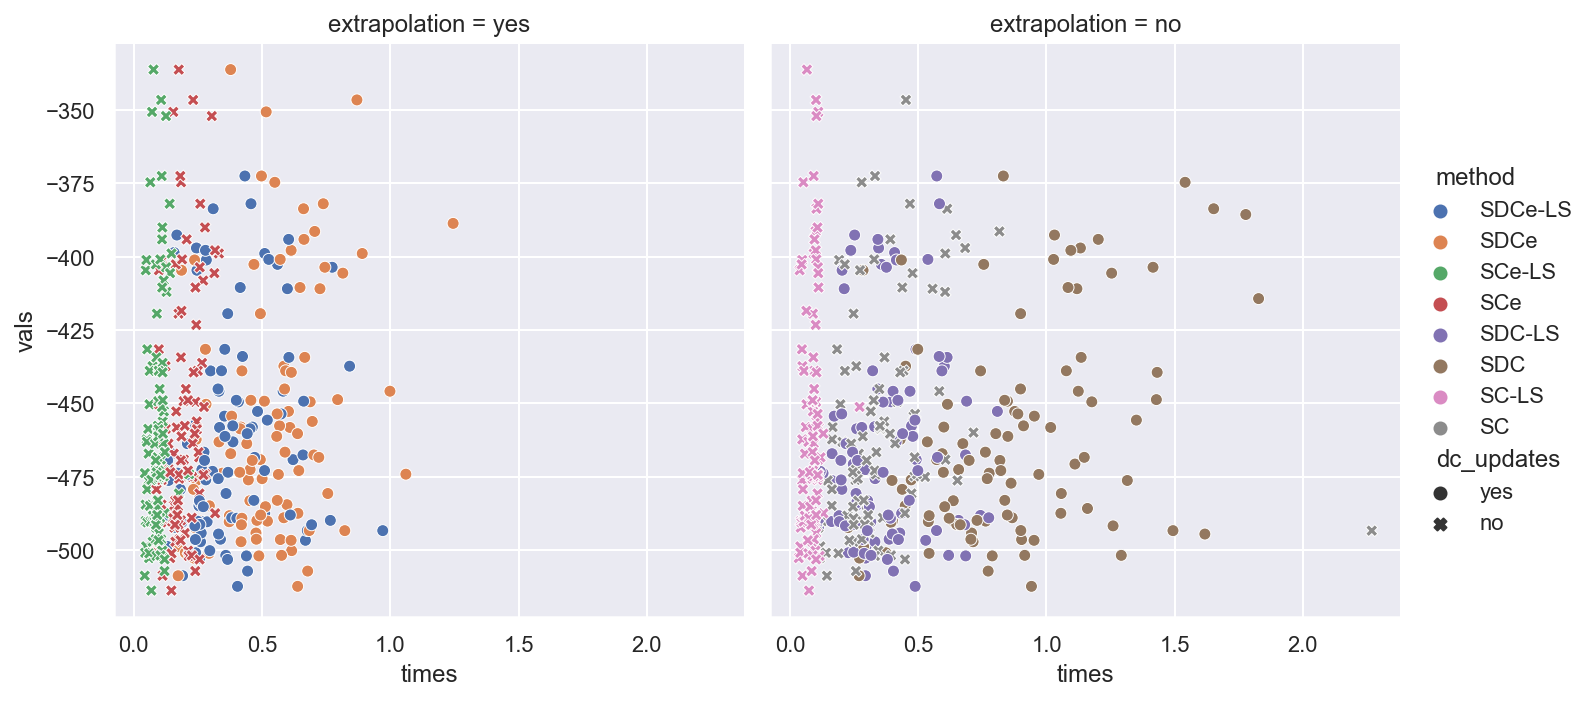

In [9]:
import seaborn as sns
sns.set_theme()
sns.relplot(
    data=subdf, x="times", y="vals",
    hue="method", style="dc_updates",
    kind="scatter",col='extrapolation'
)

In [10]:
for f in list(subdf['extrapolation'].unique()):
    subgroup = subdf[(subdf['extrapolation']==f)]
    sub = ['extrapolation: '+str(f)]
    print('subgroup: ('+str(sub)+')')
    print('avg. time: '+str(subgroup['times'].mean()))
    print('median time: '+str(subgroup['times'].median()))
    print('avg. val: '+str(subgroup['vals'].mean()))
    print('median val: '+str(subgroup['vals'].median()))
    print('avg. #iters: '+str(subgroup['iters'].mean()))
    print('median #iters: '+str(subgroup['iters'].median()))
    print(' ')

subgroup: (['extrapolation: yes'])
avg. time: 0.2951570546627045
median time: 0.2380814552307129
avg. val: -458.53460852172645
median val: -469.12642856333
avg. #iters: 16.9875
median #iters: 16.0
 
subgroup: (['extrapolation: no'])
avg. time: 0.41924534320831297
median time: 0.31587445735931396
avg. val: -460.7761012614553
median val: -470.6293696287257
avg. #iters: 25.75
median #iters: 17.5
 


In [11]:
for f in list(subdf['dc_updates'].unique()):
    subgroup = subdf[(subdf['dc_updates']==f)]
    sub = ['DC models: '+str(f)]
    print('subgroup: ('+str(sub)+')')
    print('avg. time: '+str(subgroup['times'].mean()))
    print('median time: '+str(subgroup['times'].median()))
    print('avg. val: '+str(subgroup['vals'].mean()))
    print('median val: '+str(subgroup['vals'].median()))
    print('avg. #iters: '+str(subgroup['iters'].mean()))
    print('median #iters: '+str(subgroup['iters'].median()))
    print(' ')

subgroup: (['DC models: yes'])
avg. time: 0.532779552936554
median time: 0.46683382987976074
avg. val: -462.012113297227
median val: -472.50628935178906
avg. #iters: 18.0225
median #iters: 12.5
 
subgroup: (['DC models: no'])
avg. time: 0.1816228449344635
median time: 0.11678647994995117
avg. val: -457.29859648595476
median val: -468.7341089283817
avg. #iters: 24.715
median #iters: 17.5
 


In [12]:
for f in list(subdf['method'].unique()):
    subgroup = subdf[(subdf['method']==f)]
    sub = [f]
    print('subgroup: ('+str(sub)+')')
    print('avg. time: '+str(subgroup['times'].mean()))
    print('median time: '+str(subgroup['times'].median()))
    print('avg. val: '+str(subgroup['vals'].mean()))
    print('median val: '+str(subgroup['vals'].median()))
    print('avg. #iters: '+str(subgroup['iters'].mean()))
    print('median #iters: '+str(subgroup['iters'].median()))
    print(' ')

subgroup: (['SDCe-LS'])
avg. time: 0.37427286148071287
median time: 0.3402355909347534
avg. val: -462.9838319749342
median val: -472.6779421041471
avg. #iters: 7.84
median #iters: 8.0
 
subgroup: (['SDCe'])
avg. time: 0.526444742679596
median time: 0.5149950981140137
avg. val: -457.1038920851645
median val: -467.93699823006983
avg. #iters: 21.37
median #iters: 20.0
 
subgroup: (['SCe-LS'])
avg. time: 0.09219280958175659
median time: 0.0938272476196289
avg. val: -457.8208671705883
median val: -469.2572687560626
avg. #iters: 12.71
median #iters: 12.0
 
subgroup: (['SCe'])
avg. time: 0.18771780490875245
median time: 0.1822909116744995
avg. val: -456.22984285622226
median val: -467.7169798724226
avg. #iters: 26.03
median #iters: 25.0
 
subgroup: (['SDC-LS'])
avg. time: 0.37337312698364256
median time: 0.34292030334472656
avg. val: -466.08878900777484
median val: -473.2668919428864
avg. #iters: 7.93
median #iters: 8.0
 
subgroup: (['SDC'])
avg. time: 0.8570274806022644
median time: 0.834616